In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit, logit, comb
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

import sys
sys.path.append('../')
import psix_functions as px

%run -i '~/psix/data_analysis/analysis_utils.py'

100%|██████████| 202/202 [00:01<00:00, 146.88it/s]


In [238]:
import importlib
importlib.reload(px)

<module 'psix_functions' from '../psix_functions.py'>

In [2]:
tiklova_reads = pd.read_csv('~/data_sc_regulation/tiklova_extended/skipped_exons_SJreads.tab', sep='\t',
                            index_col = 0)
tiklova_reads = tiklova_reads.loc[tiklova_PSI.index, tiklova_PSI.columns]

tiklova_reads_adj = tiklova_reads/(1+tiklova_PSI)

In [3]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/sc_splicing_regulation/utils/')
from utils_functions import *

weyn_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_pvals.tab', sep='\t', index_col=0)
weyn_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_fdr.tab', sep='\t', index_col=0)
weyn_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_psi.tab', sep='\t', index_col=0)

weyn_ds = get_averages_bulk(weyn_psi)
kw_scores = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [4]:
prob_arrays, c, c1 = px.calculate_exon_L(tiklova_PSI, W_tiklova, tiklova_mrna_event, 'Mapt_1', c = 0.1, 
                 randomize = False, version='num_denom')
prob_num, prob_denom = prob_arrays

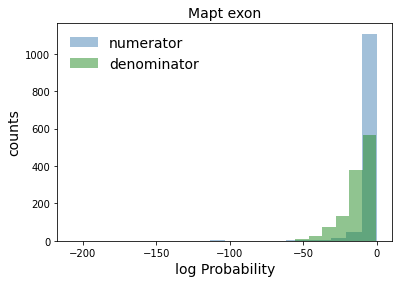

In [38]:
plt.hist(np.log(prob_num), alpha=0.5, bins=20, color='steelblue', label='numerator')
plt.hist(np.log(prob_denom), alpha=0.5, bins=20, color='forestgreen', label='denominator')
plt.xlabel('log Probability', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Mapt exon', fontsize=14)
plt.legend(frameon=False, fontsize=14)

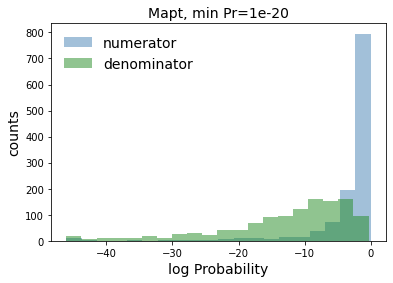

In [40]:
plt.hist(np.log([x if x > 1e-20 else 1e-20 for x in prob_num]), 
         alpha=0.5, bins=20, color='steelblue', label='numerator')
plt.hist(np.log([x if x > 1e-20 else 1e-20 for x in prob_denom]), 
         alpha=0.5, bins=20, color='forestgreen', label='denominator')
plt.xlabel('log Probability', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Mapt, min Pr=1e-20', fontsize=14)

plt.legend(frameon=False, fontsize=14)

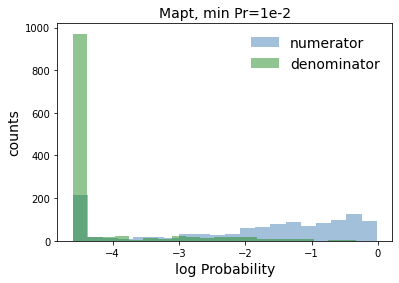

In [35]:
plt.hist(np.log([x if x > 1e-2 else 1e-2 for x in prob_num]), 
         alpha=0.5, bins=20, color='steelblue', label='numerator')
plt.hist(np.log([x if x > 1e-2 else 1e-2 for x in prob_denom]), 
         alpha=0.5, bins=20, color='forestgreen', label='denominator')
plt.xlabel('log Probability', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Mapt, min Pr=1e-2', fontsize=14)

plt.legend(frameon=False, fontsize=14)

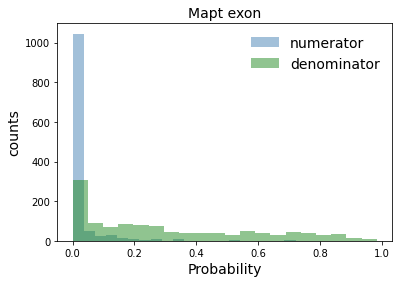

In [5]:
plt.hist(prob_denom, alpha=0.5, bins=20, color='steelblue', label='numerator')
plt.hist(prob_num, alpha=0.5, bins=20, color='forestgreen', label='denominator')

plt.xlabel('Probability', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Mapt exon', fontsize=14)

plt.legend(frameon=False, fontsize=14)

Text(0.5, 1.0, 'Mapt exon')

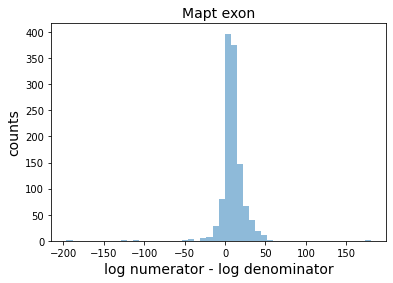

In [30]:
plt.hist(np.log(prob_num)-np.log(prob_denom), alpha=0.5, bins=50)
plt.xlabel('log numerator - log denominator', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.title('Mapt exon', fontsize=14)

In [4]:
prob_arrays_df = pd.DataFrame()
proba_num_array = []
proba_denom_array = []
c_lens = []
for exon in tqdm(tiklova_psix.index):
    prob_arrays, c, c1 = px.calculate_exon_L(tiklova_PSI, W_tiklova, tiklova_mrna_event, exon, c = 0.1, 
                 randomize = False, version='num_denom')
    prob_num, prob_denom = prob_arrays
#     prob_num = [np.max([x, 1e-2]) for x in prob_num]
#     prob_denom = [np.max([x, 1e-2]) for x in prob_denom]
    proba_num_array.append(prob_num)
    proba_denom_array.append(prob_denom)
    c_lens.append(len(c))
    
prob_arrays_df['num_array'] = proba_num_array
prob_arrays_df['denom_array'] = proba_denom_array
prob_arrays_df['cell_lens'] = c_lens
prob_arrays_df.index = tiklova_psix.index


 38%|███▊      | 753/1988 [01:05<02:00, 10.26it/s]../psix_functions.py:155: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))
 50%|████▉     | 993/1988 [01:28<02:47,  5.94it/s]../psix_functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 96%|█████████▌| 1904/1988 [03:16<00:19,  4.31it/s]../psix_functions.py:306: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
100%|██████████| 1988/1988 [03:34<00:00,  9.27it/s]


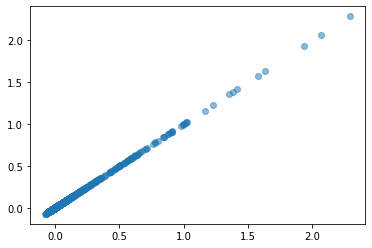

In [5]:
num_score = []
for exon in tiklova_psix.index:
    num_score.append((np.sum(np.log([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].num_array])) - np.sum(np.log([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].denom_array])))/prob_arrays_df.loc[exon].cell_lens)
    
plt.scatter(tiklova_psix.L_score, num_score, alpha=0.5)

In [5]:
def get_e_score(e):
    num_score = []
    for exon in tiklova_psix.index:
        num_score.append((np.sum(np.log([x if x > e else e for x in prob_arrays_df.loc[exon].num_array])) - np.sum(np.log([x if x > e else e for x in prob_arrays_df.loc[exon].denom_array])))/prob_arrays_df.loc[exon].cell_lens)
    return num_score
    
tiklova_psix['L_e300'] = get_e_score(1e-300)
tiklova_psix['L_e100'] = get_e_score(1e-100)
tiklova_psix['L_e10'] = get_e_score(1e-10)
tiklova_psix['L_e5'] = get_e_score(1e-5)
tiklova_psix['L_e3'] = get_e_score(1e-3)
tiklova_psix['L_005'] = get_e_score(0.005)
tiklova_psix['L_e2'] = get_e_score(1e-2)
tiklova_psix['L_02'] = get_e_score(0.02)
tiklova_psix['L_05'] = get_e_score(0.05)
tiklova_psix['L_e1'] = get_e_score(1e-1)
tiklova_psix['L_15'] = get_e_score(0.15)
tiklova_psix['L_2'] = get_e_score(0.2)

In [134]:
L_sum_score = []
num_score = []
for exon in tiklova_psix.index:
    L_sum_score.append((np.sum(np.log([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].num_array])) - np.sum(np.log([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].denom_array]))))
    num_score.append(np.sum(np.log(prob_arrays_df.loc[exon].num_array)))
    
# plt.scatter(tiklova_psix.L_score, num_score, alpha=0.5)

tiklova_psix['L_score_sum'] = L_sum_score
tiklova_psix['num_score'] = num_score

Text(0, 0.5, 'log numerator')

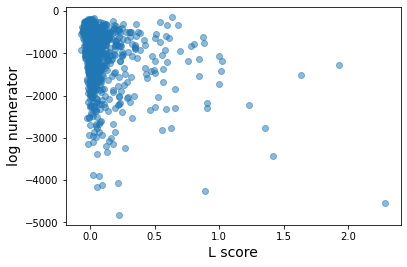

In [133]:
plt.scatter(tiklova_psix.L_score, tiklova_psix.num_score, alpha=0.5)
plt.xlabel('L score', fontsize=14)
plt.ylabel('log numerator', fontsize=14)

Text(0, 0.5, 'log numerator - log denominator')

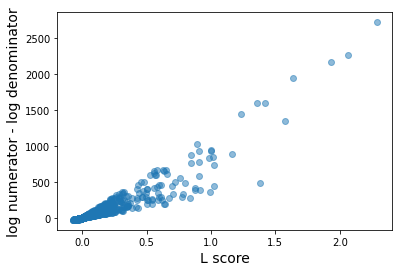

In [135]:
plt.scatter(tiklova_psix.L_score, L_sum_score, alpha=0.5)
plt.xlabel('L score', fontsize=14)
plt.ylabel('log numerator - log denominator', fontsize=14)

In [7]:
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

wx_pvals = []
mu_pvals = []
ts_pvals = []

log_wx_pvals = []
log_mu_pvals = []
log_ts_pvals = []

for exon in tqdm(tiklova_psix.index):
    mu_pvals.append(mannwhitneyu(np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].num_array]), 
                                 np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].denom_array]))[1])
    wx_pvals.append(wilcoxon(np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].num_array]), 
                              np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].denom_array]))[1])
    ts_pvals.append(ttest_ind(np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].num_array]), 
                              np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].denom_array]))[1])
    
    log_mu_pvals.append(mannwhitneyu(np.log(np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].num_array])), 
                                 np.log(np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].denom_array])))[1])
    log_wx_pvals.append(wilcoxon(np.log(np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].num_array])), 
                              np.log(np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].denom_array])))[1])
    log_ts_pvals.append(ttest_ind(np.log(np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].num_array])), 
                              np.log(np.array([x if x > 1e-2 else 1e-2 for x in prob_arrays_df.loc[exon].denom_array])))[1])
    
    
tiklova_psix['wx_pvals'] = wx_pvals
tiklova_psix['mu_pvals'] = mu_pvals
tiklova_psix['ts_pvals'] = ts_pvals

tiklova_psix['log_wx_pvals'] = log_wx_pvals
tiklova_psix['log_mu_pvals'] = log_mu_pvals
tiklova_psix['log_ts_pvals'] = log_ts_pvals

100%|██████████| 1988/1988 [00:18<00:00, 105.23it/s]


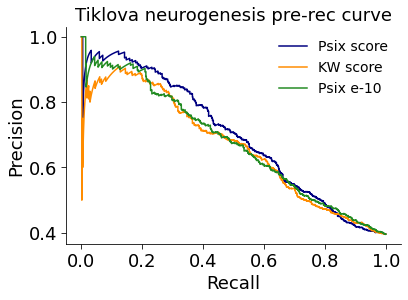

In [16]:


# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
psix_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
# psix_y1 = list(tiklova_psix.loc[weyn_pos & exons].numerator) + list(tiklova_psix.loc[weyn_neg & exons].numerator)
# psix_y1 = list(tiklova_psix.loc[weyn_pos & exons].num_score) + list(tiklova_psix.loc[weyn_neg & exons].num_score)
psix_y1 = list(tiklova_psix.loc[weyn_pos & exons].L_e100) + list(tiklova_psix.loc[weyn_neg & exons].L_e100)
psix_y2 = list(tiklova_psix.loc[weyn_pos & exons].L_e10) + list(tiklova_psix.loc[weyn_neg & exons].L_e10)
psix_y3 = list(tiklova_psix.loc[weyn_pos & exons].L_05) + list(tiklova_psix.loc[weyn_neg & exons].L_05)
psix_y4 = list(tiklova_psix.loc[weyn_pos & exons].L_e300) + list(tiklova_psix.loc[weyn_neg & exons].L_e300)

kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, psix_y)
pre2, rec2, thres2 = precision_recall_curve(y1, psix_y1)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)
pre4, rec4, thres4 = precision_recall_curve(y1, psix_y2)
pre5, rec5, thres5 = precision_recall_curve(y1, psix_y3)
pre6, rec6, thres6 = precision_recall_curve(y1, psix_y4)


plt.plot(rec1, pre1, c='navy', label='Psix score')
# plt.plot(rec2, pre2, c='steelblue', label='Psix e-100')
plt.plot(rec3, pre3, c='darkorange', label='KW score')
plt.plot(rec4, pre4, c='forestgreen', label='Psix e-10')
# plt.plot(rec5, pre5, c='indigo', label='Psix 0.05')
# plt.plot(rec6, pre6, c='gold', label='Psix e-300')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('Tiklova neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=14)

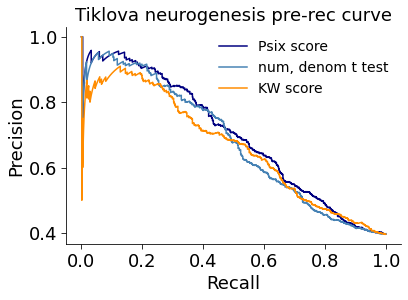

In [27]:


# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
psix_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
# psix_y1 = list(tiklova_psix.loc[weyn_pos & exons].numerator) + list(tiklova_psix.loc[weyn_neg & exons].numerator)
# psix_y1 = list(tiklova_psix.loc[weyn_pos & exons].num_score) + list(tiklova_psix.loc[weyn_neg & exons].num_score)
psix_y1 = list(-tiklova_psix.loc[weyn_pos & exons].log_ts_pvals) + list(-tiklova_psix.loc[weyn_neg & exons].log_ts_pvals)
# psix_y2 = list(tiklova_psix.loc[weyn_pos & exons].L_score_reads) + list(tiklova_psix.loc[weyn_neg & exons].L_score_reads)

kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, psix_y)
pre2, rec2, thres2 = precision_recall_curve(y1, psix_y1)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)
# pre4, rec4, thres4 = precision_recall_curve(y1, psix_y2)


plt.plot(rec1, pre1, c='navy', label='Psix score')
plt.plot(rec2, pre2, c='steelblue', label='num, denom t test')
plt.plot(rec3, pre3, c='darkorange', label='KW score')
# plt.plot(rec4, pre4, c='forestgreen', label='Psix reads')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('Tiklova neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=14)

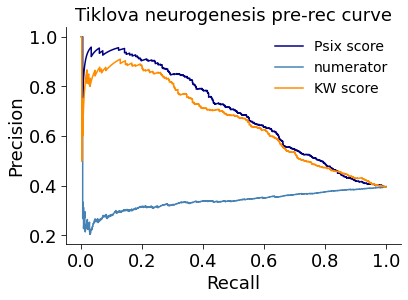

In [59]:


# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
psix_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
# psix_y1 = list(tiklova_psix.loc[weyn_pos & exons].numerator) + list(tiklova_psix.loc[weyn_neg & exons].numerator)
# psix_y1 = list(tiklova_psix.loc[weyn_pos & exons].num_score) + list(tiklova_psix.loc[weyn_neg & exons].num_score)
psix_y1 = list(tiklova_psix.loc[weyn_pos & exons].num_score) + list(tiklova_psix.loc[weyn_neg & exons].num_score)
# psix_y2 = list(tiklova_psix.loc[weyn_pos & exons].L_score_reads) + list(tiklova_psix.loc[weyn_neg & exons].L_score_reads)

kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, psix_y)
pre2, rec2, thres2 = precision_recall_curve(y1, psix_y1)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)
# pre4, rec4, thres4 = precision_recall_curve(y1, psix_y2)


plt.plot(rec1, pre1, c='navy', label='Psix score')
plt.plot(rec2, pre2, c='steelblue', label='numerator')
plt.plot(rec3, pre3, c='darkorange', label='KW score')
# plt.plot(rec4, pre4, c='forestgreen', label='Psix reads')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('Tiklova neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=14)

 99%|█████████▉| 1968/1988 [04:39<00:06,  3.29it/s]../psix_functions.py:297: RuntimeWarning: overflow encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
../psix_functions.py:297: RuntimeWarning: invalid value encountered in multiply
  prob_array = comb_1*comb_2*proba_1*proba_2
100%|██████████| 1988/1988 [04:46<00:00,  6.95it/s]


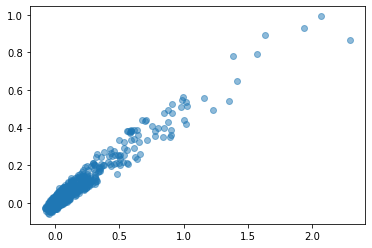

In [8]:
L_list = []
for exon in tqdm(tiklova_psix.index):
    L = px.calculate_exon_L(tiklova_PSI, W_tiklova, tiklova_reads_adj, exon, c = 0.1, 
                 randomize = False, version='psix_v1')
    L_list.append(L)

tiklova_psix['L_reads'] = L_list
plt.scatter(tiklova_psix.L_score, L_list, alpha=0.5)

In [143]:
from sklearn.metrics import auc

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
L_e300_auc = []
L_e100_auc = []
L_e10_auc = []
L_e5_auc = []
L_e3_auc = []
L_005_auc = []
L_e2_auc = []
L_05_auc = []
L_02_auc = []
L_e1_auc = []
L_15_auc = []
L_2_auc = []
L_reads_auc = []

L_sum_auc = []

for sample in tqdm(range(100)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list(tiklova_psix.loc[pos_choice].L_score) + list(tiklova_psix.loc[neg_choice].L_score)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e2_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_e100) + list(tiklova_psix.loc[neg_choice].L_e100)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e100_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_e3) + list(tiklova_psix.loc[neg_choice].L_e3)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e3_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_e5) + list(tiklova_psix.loc[neg_choice].L_e5)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e5_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_e10) + list(tiklova_psix.loc[neg_choice].L_e10)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e10_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_e1) + list(tiklova_psix.loc[neg_choice].L_e1)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e1_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_e300) + list(tiklova_psix.loc[neg_choice].L_e300)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_e300_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_005) + list(tiklova_psix.loc[neg_choice].L_005)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_005_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_05) + list(tiklova_psix.loc[neg_choice].L_05)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_05_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_02) + list(tiklova_psix.loc[neg_choice].L_02)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_02_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_15) + list(tiklova_psix.loc[neg_choice].L_15)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_15_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_2) + list(tiklova_psix.loc[neg_choice].L_2)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_2_auc.append(auc(rec, pre))
    
    psix_y = list(tiklova_psix.loc[pos_choice].L_score_sum) + list(tiklova_psix.loc[neg_choice].L_score_sum)
    pre, rec, thres = precision_recall_curve(y, psix_y)
    L_sum_auc.append(auc(rec, pre))
    
    kw_y = list(tiklova_kw.loc[pos_choice].KW_score) + list(tiklova_kw.loc[neg_choice].KW_score)
    pre, rec, thres = precision_recall_curve(y, kw_y)
    kw_auc.append(auc(rec, pre))
    
    r_y = list(tiklova_psix.loc[pos_choice].L_reads) + list(tiklova_psix.loc[neg_choice].L_reads)
    pre, rec, thres = precision_recall_curve(y, r_y)
    L_reads_auc.append(auc(rec, pre))

100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


Text(0.5, 1.0, 'Psix performance')

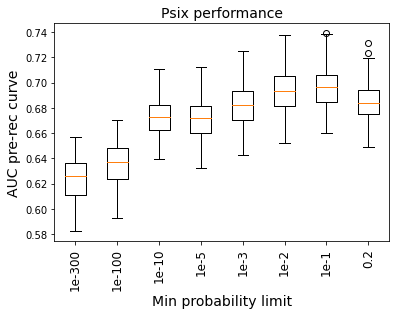

In [144]:
bp = plt.boxplot(
    [L_e300_auc, L_e100_auc, L_e10_auc, L_e5_auc,L_e3_auc, L_e2_auc, L_e1_auc, L_2_auc]
)

# for item in bp.get_xticklabels():
#     item.set_rotation(90)

plt.xticks(np.arange(1, 9), 
           ['1e-300', '1e-100', '1e-10', '1e-5', '1e-3', '1e-2', '1e-1', '0.2'], 
           fontsize=12, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
plt.xlabel('Min probability limit', fontsize=14)
plt.title('Psix performance', fontsize=14)

Text(0.5, 1.0, 'Psix performance')

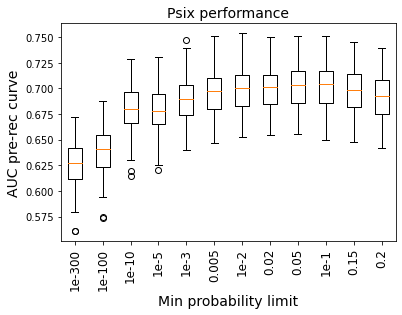

In [29]:
bp = plt.boxplot(
    [L_e300_auc, L_e100_auc, L_e10_auc, L_e5_auc,L_e3_auc,  L_005_auc, L_e2_auc, L_02_auc, L_05_auc, 
     L_e1_auc, L_15_auc, L_2_auc]
)

# for item in bp.get_xticklabels():
#     item.set_rotation(90)

plt.xticks(np.arange(1, 13), 
           ['1e-300', '1e-100', '1e-10', '1e-5', '1e-3', '0.005', '1e-2', '0.02', '0.05', '1e-1', '0.15', '0.2'], 
           fontsize=12, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
plt.xlabel('Min probability limit', fontsize=14)
plt.title('Psix performance', fontsize=14)

Text(0.5, 1.0, 'Method comparison')

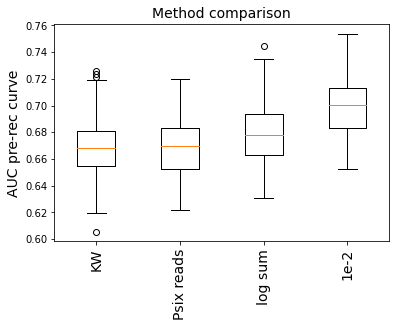

In [30]:
bp = plt.boxplot(
    [kw_auc, L_reads_auc, L_sum_auc, L_e2_auc]
)


plt.xticks(np.arange(1, 5), 
           ['KW', 'Psix reads', 'log sum', '1e-2'], fontsize=14, rotation=90)

plt.ylabel('AUC pre-rec curve', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Method comparison', fontsize=14)


In [9]:
tiklova_constant_r = pd.DataFrame(10*np.ones(tiklova_mrna_event.shape))
tiklova_constant_r.index = tiklova_mrna_event.index
tiklova_constant_r.columns = tiklova_mrna_event.columns

In [10]:
L_list = []
for exon in tqdm(tiklova_psix.index):
    L = px.calculate_exon_L(tiklova_PSI, W_tiklova, tiklova_constant_r, exon, c = 0.1, 
                 randomize = False, version='psix_v1')
    L_list.append(L)


100%|██████████| 1988/1988 [04:49<00:00,  6.86it/s]


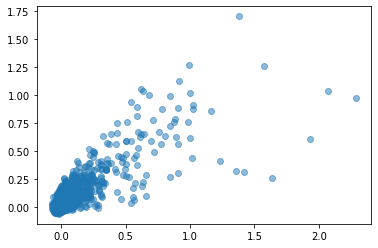

In [12]:
tiklova_psix['L_constant'] = L_list
plt.scatter(tiklova_psix.L_score, L_list, alpha=0.5)

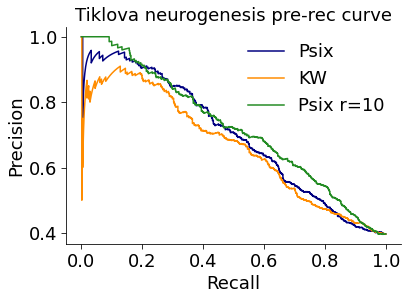

In [34]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/sc_splicing_regulation/utils/')
from utils_functions import *

weyn_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_pvals.tab', sep='\t', index_col=0)
weyn_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_fdr.tab', sep='\t', index_col=0)
weyn_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_psi.tab', sep='\t', index_col=0)

weyn_ds = get_averages_bulk(weyn_psi)
kw_scores = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
psix_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
# psix_y1 = list(tiklova_psix.loc[weyn_pos & exons].numerator) + list(tiklova_psix.loc[weyn_neg & exons].numerator)
# psix_y1 = list(tiklova_psix.loc[weyn_pos & exons].num_score) + list(tiklova_psix.loc[weyn_neg & exons].num_score)
# psix_y1 = list(tiklova_psix.loc[weyn_pos & exons].fixed_L) + list(tiklova_psix.loc[weyn_neg & exons].fixed_L)
psix_y2 = list(tiklova_psix.loc[weyn_pos & exons].L_constant) + list(tiklova_psix.loc[weyn_neg & exons].L_constant)

kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, psix_y)
# pre2, rec2, thres2 = precision_recall_curve(y1, psix_y1)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)
pre4, rec4, thres4 = precision_recall_curve(y1, psix_y2)


plt.plot(rec1, pre1, c='navy', label='Psix')
# plt.plot(rec2, pre2, c='steelblue', label='Psix fixed')
plt.plot(rec3, pre3, c='darkorange', label='KW')
plt.plot(rec4, pre4, c='forestgreen', label='Psix r=10')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('Tiklova neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

In [13]:
L_score_adj = tiklova_psix.L_score/(np.max(tiklova_psix.L_score) - np.min(tiklova_psix.L_score))
L_constant_adj = tiklova_psix.L_constant/(np.max(tiklova_psix.L_constant) - np.min(tiklova_psix.L_constant))

In [14]:
(L_score_adj-L_constant_adj).sort_values()[-5:]

Ncam1_6     0.390261
Mapt_1      0.416906
Cadm1_10    0.421100
Dbn1_1      0.474326
Mapt_3      0.544692
dtype: float64

In [68]:
(L_score_adj-L_constant_adj).sort_values()[:5]

Dst_5       -0.378797
Golga2_2    -0.334900
C2cd5_4     -0.317022
Sorbs1_13   -0.300856
Dlg2_4      -0.298257
dtype: float64

In [73]:
tiklova_psix.loc['Dst_5']

bin             mean_1_var_5
L_score              1.38341
pvals            0.000999001
qvals             0.00376853
norm_pvals                 0
norm_qvals                 0
L_e300             -0.683648
L_e100              0.632115
L_e10                1.26057
L_e5                 1.32636
L_e3                 1.36605
L_005                1.38513
L_e2                 1.38341
L_02                 1.36292
L_05                 1.29061
L_e1                 1.17994
L_15                 1.08147
L_2                  1.00098
L_score_sum          484.194
num_score               -inf
wx_pvals         1.62946e-57
mu_pvals         3.19475e-94
ts_pvals        5.07278e-170
log_wx_pvals     1.41851e-49
log_mu_pvals     3.19475e-94
log_ts_pvals     8.79892e-66
L_reads             0.779036
L_constant           1.70348
Name: Dst_5, dtype: object

Text(0.5, 1.0, 'Cadm1_10 exon')

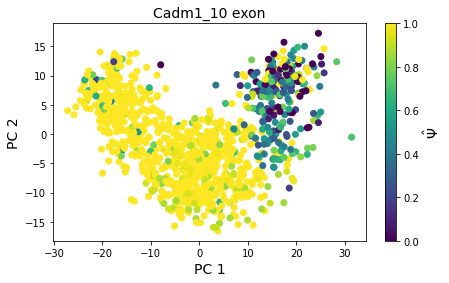

In [69]:
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Cadm1_10'])
cb = plt.colorbar(sc)
cb.set_label('$\hat{\Psi}$', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Cadm1_10 exon', fontsize=14)

Text(0.5, 1.0, 'Cadm1_10 exon')

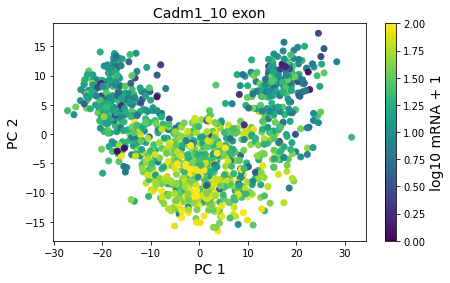

In [70]:
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=np.log10(tiklova_mrna_event.loc['Cadm1_10']+1), vmin=0, vmax=2)
cb = plt.colorbar(sc)
cb.set_label('log10 mRNA + 1', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Cadm1_10 exon', fontsize=14)

(-0.05, 2.05)

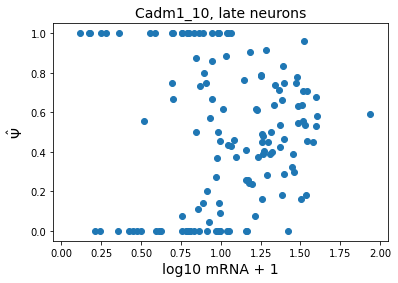

In [71]:
x = pseudotime.loc[pseudotime.lineage_1_pseudotime > 45].index & tiklova_rd.index

plt.scatter(np.log10(tiklova_mrna_event.loc['Cadm1_10', x]+1), tiklova_PSI.loc['Cadm1_10', x])
plt.xlabel('log10 mRNA + 1', fontsize=14)
plt.ylabel('$\hat{\Psi}$', fontsize=14)
plt.title('Cadm1_10, late neurons', fontsize=14)
plt.ylim((-0.05, 1.05))
plt.xlim((-0.05, 2.05))

(-0.05, 2.05)

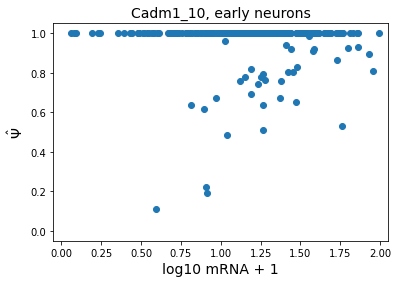

In [72]:
x = pseudotime.loc[pseudotime.lineage_1_pseudotime < 15].index & tiklova_rd.index

plt.scatter(np.log10(tiklova_mrna_event.loc['Cadm1_10', x]+1), tiklova_PSI.loc['Cadm1_10', x])
plt.xlabel('log10 mRNA + 1', fontsize=14)
plt.ylabel('$\hat{\Psi}$', fontsize=14)
plt.title('Cadm1_10, early neurons', fontsize=14)
plt.ylim((-0.05, 1.05))
plt.xlim((-0.05, 2.05))

Text(0.5, 1.0, 'Dst_5 exon')

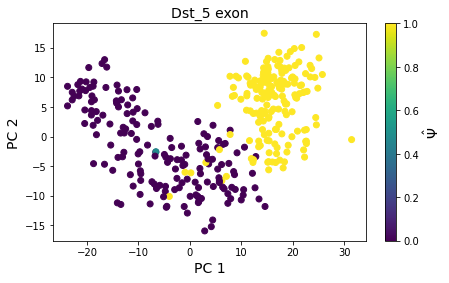

In [76]:
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Dst_5'])
cb = plt.colorbar(sc)
cb.set_label('$\hat{\Psi}$', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Dst_5 exon', fontsize=14)

Text(0.5, 1.0, 'Dst_5 exon')

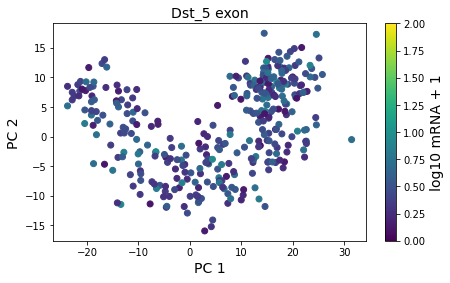

In [81]:
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=np.log10(tiklova_mrna_event.loc['Dst_5']+1), vmin=0, vmax=2)
cb = plt.colorbar(sc)
cb.set_label('log10 mRNA + 1', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Dst_5 exon', fontsize=14)

(-0.05, 2.05)

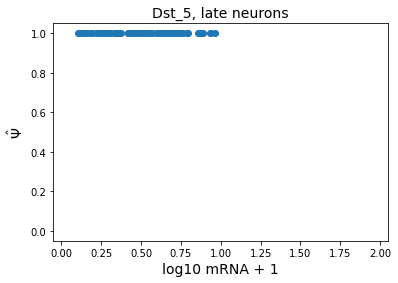

In [146]:
x = pseudotime.loc[pseudotime.lineage_1_pseudotime > 45].index & tiklova_rd.index

plt.scatter(np.log10(tiklova_mrna_event.loc['Dst_5', x]+1), tiklova_PSI.loc['Dst_5', x])
plt.xlabel('log10 mRNA + 1', fontsize=14)
plt.ylabel('$\hat{\Psi}$', fontsize=14)
plt.title('Dst_5, late neurons', fontsize=14)
plt.ylim((-0.05, 1.05))
plt.xlim((-0.05, 2.05))

(-0.05, 2.05)

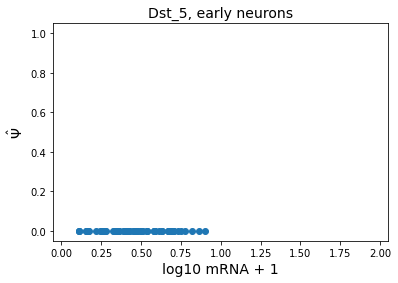

In [60]:
x = pseudotime.loc[pseudotime.lineage_1_pseudotime < 15].index & tiklova_rd.index

plt.scatter(np.log10(tiklova_mrna_event.loc['Dst_5', x]+1), tiklova_PSI.loc['Dst_5', x])
plt.xlabel('log10 mRNA + 1', fontsize=14)
plt.ylabel('$\hat{\Psi}$', fontsize=14)
plt.title('Dst_5, early neurons', fontsize=14)
plt.ylim((-0.05, 1.05))
plt.xlim((-0.05, 2.05))

In [61]:
np.log10(3)

0.47712125471966244

(-0.05, 1.05)

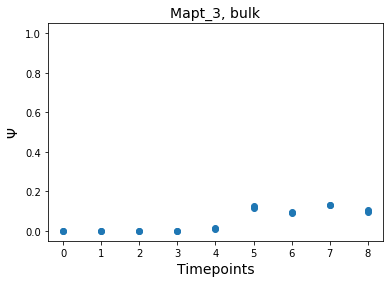

In [154]:
plt.scatter([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8],
            weyn_psi.loc['Mapt_3'])
plt.xlabel('Timepoints', fontsize=14)
plt.ylabel('$\Psi$', fontsize=14)
plt.title('Mapt_3, bulk', fontsize=14)
plt.ylim(-0.05, 1.05)

(-0.05, 1.05)

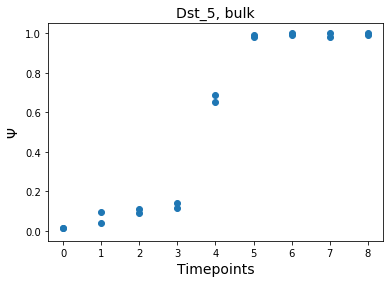

In [155]:
plt.scatter([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8],
            weyn_psi.loc['Dst_5'])
plt.xlabel('Timepoints', fontsize=14)
plt.ylabel('$\Psi$', fontsize=14)
plt.title('Dst_5, bulk', fontsize=14)
plt.ylim(-0.05, 1.05)

Text(0.5, 1.0, 'Mapt_3 exon')

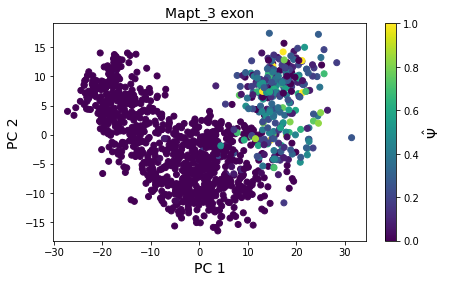

In [56]:
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Mapt_3'])
cb = plt.colorbar(sc)
cb.set_label('$\hat{\Psi}$', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Mapt_3 exon', fontsize=14)

Text(0.5, 1.0, 'Mapt_3 exon')

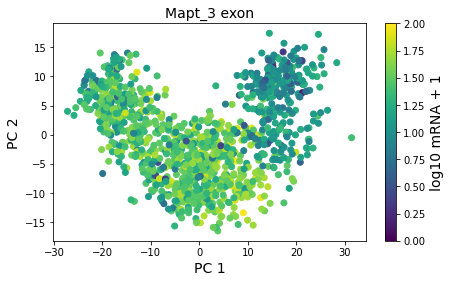

In [82]:
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=np.log10(tiklova_mrna_event.loc['Mapt_3']+1), vmin=0, vmax=2)
cb = plt.colorbar(sc)
cb.set_label('log10 mRNA + 1', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Mapt_3 exon', fontsize=14)

(-0.05, 2.05)

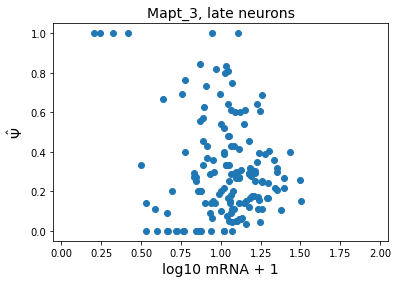

In [68]:
x = pseudotime.loc[pseudotime.lineage_1_pseudotime > 45].index & tiklova_rd.index

plt.scatter(np.log10(tiklova_mrna_event.loc['Mapt_3', x]+1), tiklova_PSI.loc['Mapt_3', x])
plt.xlabel('log10 mRNA + 1', fontsize=14)
plt.ylabel('$\hat{\Psi}$', fontsize=14)
plt.title('Mapt_3, late neurons', fontsize=14)
plt.ylim((-0.05, 1.05))
plt.xlim((-0.05, 2.05))

(-0.05, 2.05)

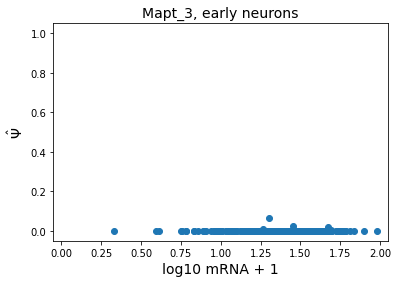

In [71]:
x = pseudotime.loc[pseudotime.lineage_1_pseudotime < 15].index & tiklova_rd.index

plt.scatter(np.log10(tiklova_mrna_event.loc['Mapt_3', x]+1), tiklova_PSI.loc['Mapt_3', x])
plt.xlabel('log10 mRNA + 1', fontsize=14)
plt.ylabel('$\hat{\Psi}$', fontsize=14)
plt.title('Mapt_3, early neurons', fontsize=14)
plt.ylim((-0.05, 1.05))
plt.xlim((-0.05, 2.05))

Text(0.5, 1.0, 'Mapt_3 exon')

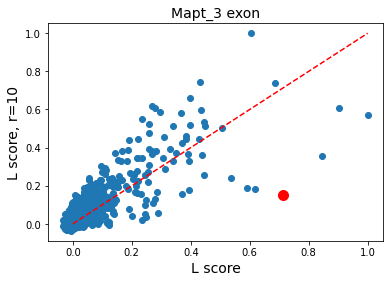

In [18]:
plt.scatter((tiklova_psix.L_score/np.max(tiklova_psix.L_score)),(tiklova_psix.L_constant/np.max(tiklova_psix.L_constant)))
plt.plot([0, 1], [0, 1], 'r--')

plt.scatter([tiklova_psix.loc['Mapt_3'].L_score/np.max(tiklova_psix.L_score)], 
            [tiklova_psix.loc['Mapt_3'].L_constant/np.max(tiklova_psix.L_constant)], c='red', s=100)
plt.xlabel('L score', fontsize=14)
plt.ylabel('L score, r=10', fontsize=14)
plt.title('Mapt_3 exon', fontsize=14)

Text(0.5, 1.0, 'Dst_5 exon')

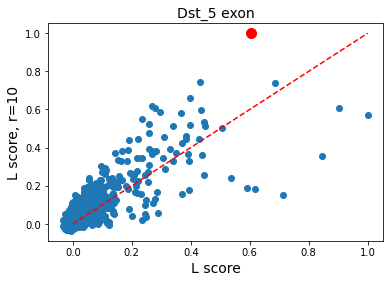

In [19]:
plt.scatter((tiklova_psix.L_score/np.max(tiklova_psix.L_score)),(tiklova_psix.L_constant/np.max(tiklova_psix.L_constant)))
plt.plot([0, 1], [0, 1], 'r--')

plt.scatter([tiklova_psix.loc['Dst_5'].L_score/np.max(tiklova_psix.L_score)], 
            [tiklova_psix.loc['Dst_5'].L_constant/np.max(tiklova_psix.L_constant)], c='red', s=100)

plt.xlabel('L score', fontsize=14)
plt.ylabel('L score, r=10', fontsize=14)
plt.title('Dst_5 exon', fontsize=14)

In [112]:
tiklova_psix.loc[(L_score_adj >= 0.05) & (L_constant_adj <= 0)]

,bin,L_score,pvals,qvals,norm_pvals,norm_qvals,L_e300,L_e100,L_e10,L_e5,...,L_score_sum,num_score,wx_pvals,mu_pvals,ts_pvals,log_wx_pvals,log_mu_pvals,log_ts_pvals,L_reads,L_constant
P4htm_1,mean_2_var_2,0.195173,0.000999,0.003769,2.504728e-45,3.688443e-44,0.134260,0.134260,0.143983,0.209550,...,117.494407,-802.731104,2.459813e-16,4.754110e-08,1.142643e-07,1.950170e-12,4.754110e-08,4.502670e-03,0.087600,-0.001296
Peg3_nmdSE_1,mean_3_var_1,0.282564,0.000999,0.003769,1.538736e-135,4.706165e-134,0.199175,0.199175,0.232683,0.276349,...,293.018669,-1687.287739,1.752394e-03,1.394606e-08,1.670048e-08,2.708639e-04,1.394606e-08,9.924829e-07,0.112967,-0.012800
Snhg11_nmdSE_1,mean_4_var_1,0.146866,0.000999,0.003769,1.671836e-17,1.531618e-16,0.193271,0.193271,0.193271,0.190298,...,140.551213,-2071.574589,3.763704e-09,3.079659e-03,2.683039e-01,4.049152e-11,3.079659e-03,8.556945e-03,0.048410,-0.012318


Text(0.5, 1.0, 'Peg3_nmdSE_1 exon')

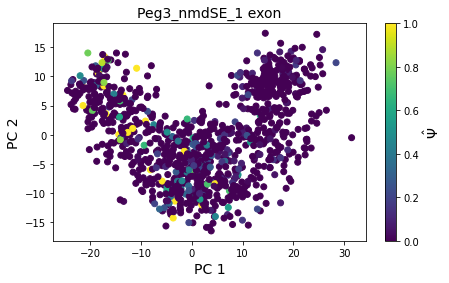

In [157]:
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Peg3_nmdSE_1'])
cb = plt.colorbar(sc)
cb.set_label('$\hat{\Psi}$', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Peg3_nmdSE_1 exon', fontsize=14)

In [124]:
weyn_psi.loc['Snhg11_nmdSE_1']

E14_rep1     0.082
E14_rep2     0.090
E16_rep1     0.084
E16_rep2     0.088
P0_rep1      0.078
P0_rep2      0.056
P4_rep1      0.040
P4_rep2      0.050
P7_rep1      0.040
P7_rep2      0.036
P15_rep1     0.039
P15_rep2     0.070
P30_rep1     0.061
P30_rep2     0.056
P110_rep1    0.077
P110_rep2    0.063
M21_rep1     0.070
M21_rep2     0.068
Name: Snhg11_nmdSE_1, dtype: float64

In [113]:
tiklova_psix.loc[(L_score_adj <= 0) & (L_constant_adj >= 0.05)]

,bin,L_score,pvals,qvals,norm_pvals,norm_qvals,L_e300,L_e100,L_e10,L_e5,...,L_score_sum,num_score,wx_pvals,mu_pvals,ts_pvals,log_wx_pvals,log_mu_pvals,log_ts_pvals,L_reads,L_constant
Armcx1_3,mean_1_var_4,-0.002127,0.168831,0.278536,0.230070,0.363576,-0.007770,-0.007770,-0.007770,-0.007770,...,-1.273778,-843.611623,0.006807,0.079002,0.720489,0.508431,0.079002,0.975976,0.012392,0.099182
Btbd10_4,mean_1_var_4,-0.000412,0.150849,0.258524,0.204385,0.334693,-0.015112,-0.015112,-0.015112,-0.011987,...,-0.318551,-1355.393113,0.000181,0.148745,0.504578,0.286323,0.148745,0.994969,0.008937,0.104946
Epb41_3,mean_1_var_4,-0.018559,0.551449,0.681766,0.539530,0.658925,-0.030807,-0.030807,-0.030807,-0.030807,...,-6.365692,-333.625119,0.009072,0.101298,0.635830,0.278846,0.101298,0.785847,0.005861,0.098851
Pi4kb_1,mean_1_var_4,-0.025416,0.739261,0.836931,0.673241,0.774091,-0.058601,-0.058601,-0.058601,-0.058601,...,-7.853505,-441.537797,0.011613,0.299219,0.402039,0.374301,0.299219,0.771833,0.013930,0.114142
Prpsap2_3,mean_1_var_4,-0.000021,0.150849,0.258524,0.198790,0.327545,-0.040626,-0.040626,-0.040626,-0.040626,...,-0.009575,-482.760476,0.000120,0.022337,0.290602,0.066870,0.022337,0.999745,-0.013730,0.111760
Slc4a10_1,mean_1_var_4,-0.003758,0.213786,0.334915,0.256101,0.390576,-4.557003,-1.497089,-0.120128,-0.043630,...,-1.131259,-inf,0.001377,0.011027,0.202883,0.066839,0.011027,0.954493,0.000548,0.188835
Ube2i_4,mean_1_var_4,-0.013223,0.408591,0.543695,0.431394,0.564166,-0.028866,-0.028866,-0.028866,-0.028866,...,-4.178428,-362.809998,0.098241,0.158922,0.546842,0.390073,0.158922,0.884937,-0.022807,0.112082
Alkbh3_3,mean_1_var_5,-0.013413,0.325674,0.459504,0.364246,0.500466,-0.023240,-0.023240,-0.023240,-0.015758,...,-4.372592,-501.465805,0.934843,0.350777,0.924204,0.585813,0.350777,0.893500,-0.023002,0.126933
Cbx5_1,mean_1_var_5,-0.006612,0.231768,0.354427,0.248334,0.382703,-0.034772,-0.034772,-0.034772,-0.034185,...,-2.638263,-465.822918,0.306675,0.367517,0.787036,0.822620,0.367517,0.921784,-0.009230,0.121751
Cbx5_3,mean_1_var_5,-0.010426,0.292707,0.423818,0.310927,0.448566,-0.032194,-0.032194,-0.032194,-0.032194,...,-4.149478,-450.128223,0.434560,0.399021,0.877873,0.768254,0.399021,0.874513,-0.011168,0.107487


Text(0.5, 1.0, 'Pbx4_1')

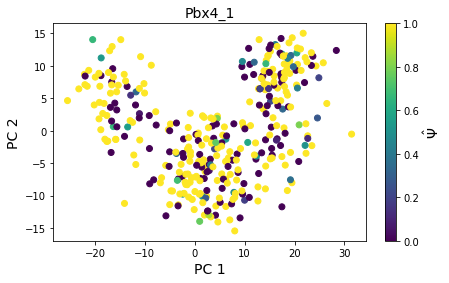

In [125]:
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Pbx4_1'])
cb = plt.colorbar(sc)
cb.set_label('$\hat{\Psi}$', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Pbx4_1', fontsize=14)

Text(0.5, 1.0, 'Pbx4_1')

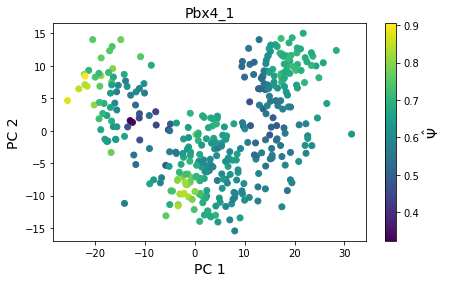

In [132]:
cell_list = tiklova_PSI.loc['Pbx4_1'].dropna().index
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.loc[cell_list].PC_1, tiklova_rd.loc[cell_list].PC_2, 
                 c=np.array(pd.DataFrame(
        np.array(W_tiklova.loc[cell_list, cell_list])*np.array(tiklova_PSI.loc['Pbx4_1'].dropna())).sum(axis=1)
    )/np.array(W_tiklova.loc[cell_list, cell_list].sum(axis=1)))
cb = plt.colorbar(sc)
cb.set_label('$\hat{\Psi}$', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Pbx4_1', fontsize=14)

In [127]:
weyn_fdr.loc['Pbx4_1']

E16     0.544450
P0      0.101872
P4      0.013221
P7      0.000904
P15     0.015070
P30     0.488611
P110    0.040611
M21     0.114271
Name: Pbx4_1, dtype: float64

In [128]:
weyn_ds.loc['Pbx4_1']

E16     0.0915
P0      0.1350
P4      0.2065
P7      0.2385
P15     0.2090
P30     0.1160
P110    0.1600
M21     0.1375
Name: Pbx4_1, dtype: float64

Text(0.5, 1.0, 'Mbnl1_3 exon')

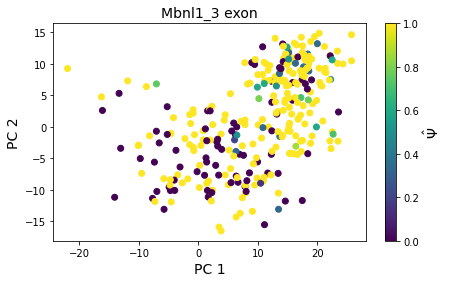

In [77]:
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Slc4a10_1'])
cb = plt.colorbar(sc)
cb.set_label('$\hat{\Psi}$', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Mbnl1_3 exon', fontsize=14)

In [122]:
weyn_psi.loc['Slc4a10_1']

E14_rep1     1.000
E14_rep2     0.716
E16_rep1     0.760
E16_rep2     0.750
P0_rep1      0.725
P0_rep2      0.611
P4_rep1      0.698
P4_rep2      0.628
P7_rep1      0.834
P7_rep2      0.812
P15_rep1     0.918
P15_rep2     0.935
P30_rep1     0.922
P30_rep2     0.945
P110_rep1    0.928
P110_rep2    0.935
M21_rep1     0.946
M21_rep2     0.935
Name: Slc4a10_1, dtype: float64

Text(0.5, 1.0, 'Mbnl1_3 exon')

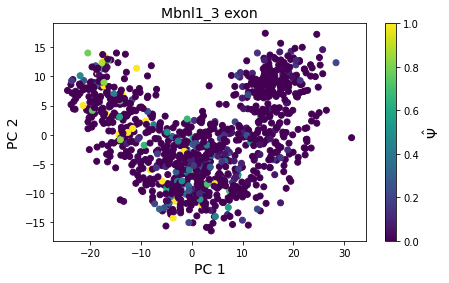

In [72]:
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Peg3_nmdSE_1'])
cb = plt.colorbar(sc)
cb.set_label('$\hat{\Psi}$', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Mbnl1_3 exon', fontsize=14)

Text(0.5, 1.0, 'Peg3_nmdSE_1 exon')

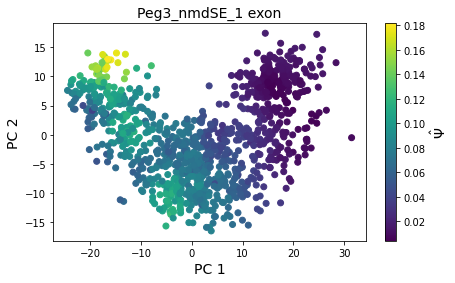

In [103]:
cell_list = tiklova_PSI.loc['Peg3_nmdSE_1'].dropna().index
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.loc[cell_list].PC_1, tiklova_rd.loc[cell_list].PC_2, 
                 c = np.array(pd.DataFrame(
        np.array(W_tiklova.loc[cell_list, cell_list])*np.array(tiklova_PSI.loc['Peg3_nmdSE_1'].dropna())).sum(axis=1)
    )/np.array(W_tiklova.loc[cell_list, cell_list].sum(axis=1)))
cb = plt.colorbar(sc)
cb.set_label('$\hat{\Psi}$', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Peg3_nmdSE_1 exon', fontsize=14)

/mnt/lareaulab/cfbuenabadn/psix/data_analysis/analysis_utils.py:6: RuntimeWarning: invalid value encountered in true_divide
  import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Slc4a10_1 exon')

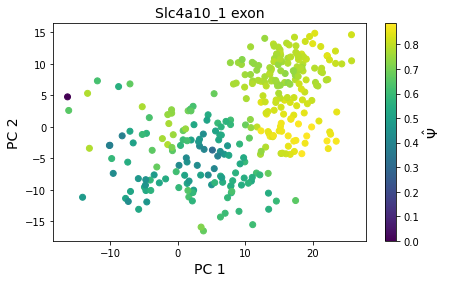

In [104]:
cell_list = tiklova_PSI.loc['Slc4a10_1'].dropna().index
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.loc[cell_list].PC_1, tiklova_rd.loc[cell_list].PC_2, 
                 c = np.array(pd.DataFrame(
        np.array(W_tiklova.loc[cell_list, cell_list])*np.array(tiklova_PSI.loc['Slc4a10_1'].dropna())).sum(axis=1)
    )/np.array(W_tiklova.loc[cell_list, cell_list].sum(axis=1)))
cb = plt.colorbar(sc)
cb.set_label('$\hat{\Psi}$', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Slc4a10_1 exon', fontsize=14)

Text(0.5, 1.0, 'Slc4a10_1 exon')

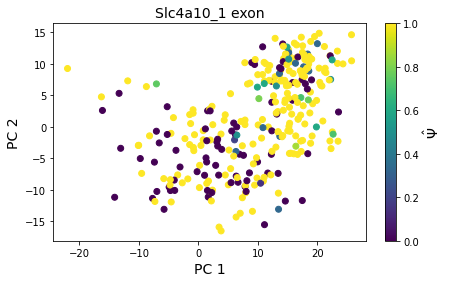

In [106]:
plt.figure(figsize=(7, 4))
sc = plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Slc4a10_1'])
cb = plt.colorbar(sc)
cb.set_label('$\hat{\Psi}$', fontsize=14)
plt.xlabel('PC 1', fontsize=14)
plt.ylabel('PC 2', fontsize=14)
plt.title('Slc4a10_1 exon', fontsize=14)

In [109]:
weyn_ds.loc['Slc4a10_1']

E16     0.1030
P0      0.1900
P4      0.1950
P7      0.0350
P15     0.0685
P30     0.0755
P110    0.0735
M21     0.0825
Name: Slc4a10_1, dtype: float64

In [111]:
weyn_ds.loc['Peg3_nmdSE_1']

E16     0.0655
P0      0.0810
P4      0.0215
P7      0.0510
P15     0.0970
P30     0.0990
P110    0.0595
M21     0.0580
Name: Peg3_nmdSE_1, dtype: float64

(-0.05, 2.05)

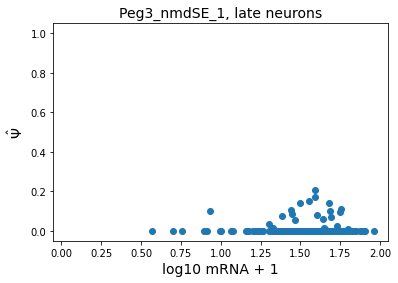

In [73]:
x = pseudotime.loc[pseudotime.lineage_1_pseudotime > 45].index & tiklova_rd.index

plt.scatter(np.log10(tiklova_mrna_event.loc['Peg3_nmdSE_1', x]+1), tiklova_PSI.loc['Peg3_nmdSE_1', x])
plt.xlabel('log10 mRNA + 1', fontsize=14)
plt.ylabel('$\hat{\Psi}$', fontsize=14)
plt.title('Peg3_nmdSE_1, late neurons', fontsize=14)
plt.ylim((-0.05, 1.05))
plt.xlim((-0.05, 2.05))

(-0.05, 2.05)

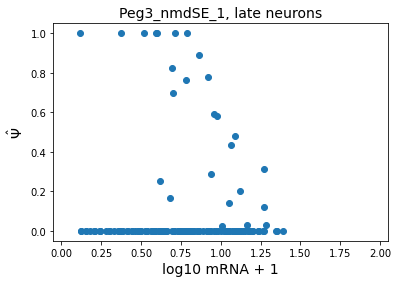

In [75]:
x = pseudotime.loc[pseudotime.lineage_1_pseudotime < 10].index & tiklova_rd.index

plt.scatter(np.log10(tiklova_mrna_event.loc['Peg3_nmdSE_1', x]+1), tiklova_PSI.loc['Peg3_nmdSE_1', x])
plt.xlabel('log10 mRNA + 1', fontsize=14)
plt.ylabel('$\hat{\Psi}$', fontsize=14)
plt.title('Peg3_nmdSE_1, late neurons', fontsize=14)
plt.ylim((-0.05, 1.05))
plt.xlim((-0.05, 2.05))

In [78]:
np.log10(tiklova_mrna_event.loc['Peg3_nmdSE_1']+1).mean()

1.103194789640991

(-0.05, 2.05)

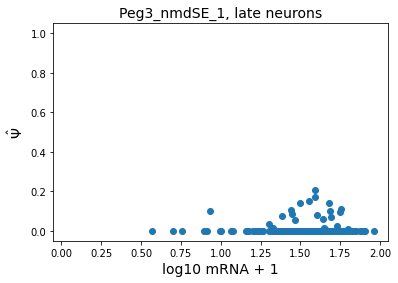

In [79]:
x = pseudotime.loc[pseudotime.lineage_1_pseudotime > 45].index & tiklova_rd.index

plt.scatter(np.log10(tiklova_mrna_event.loc['Peg3_nmdSE_1', x]+1), tiklova_PSI.loc['Peg3_nmdSE_1', x])
plt.xlabel('log10 mRNA + 1', fontsize=14)
plt.ylabel('$\hat{\Psi}$', fontsize=14)
plt.title('Peg3_nmdSE_1, late neurons', fontsize=14)
plt.ylim((-0.05, 1.05))
plt.xlim((-0.05, 2.05))

(-0.05, 2.05)

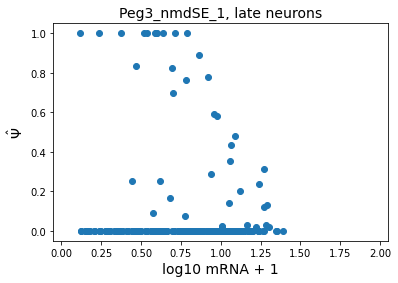

In [80]:
x = pseudotime.loc[pseudotime.lineage_1_pseudotime < 15].index & tiklova_rd.index

plt.scatter(np.log10(tiklova_mrna_event.loc['Peg3_nmdSE_1', x]+1), tiklova_PSI.loc['Peg3_nmdSE_1', x])
plt.xlabel('log10 mRNA + 1', fontsize=14)
plt.ylabel('$\hat{\Psi}$', fontsize=14)
plt.title('Peg3_nmdSE_1, late neurons', fontsize=14)
plt.ylim((-0.05, 1.05))
plt.xlim((-0.05, 2.05))

In [20]:
(L_score_adj-L_constant_adj).sort_values()

Dst_5       -0.378797
Golga2_2    -0.334900
C2cd5_4     -0.317022
Sorbs1_13   -0.300856
Dlg2_4      -0.298257
               ...   
Ncam1_6      0.390261
Mapt_1       0.416906
Cadm1_10     0.421100
Dbn1_1       0.474326
Mapt_3       0.544692
Length: 1988, dtype: float64

Text(0.5, 1.0, 'All exons')

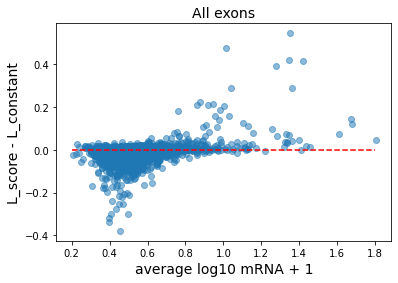

In [79]:
x = (L_score_adj-L_constant_adj).sort_values().index
plt.scatter(np.log10(tiklova_mrna_event.loc[x]+1).mean(axis=1), (L_score_adj-L_constant_adj).sort_values(), alpha=0.5)
plt.plot([0.2, 1.8], [0, 0], 'r--')
plt.xlabel('average log10 mRNA + 1', fontsize=14)
plt.ylabel('L_score - L_constant', fontsize=14)
plt.title('All exons', fontsize=14)

In [57]:
pos_L = tiklova_psix.loc[(L_score_adj > 0) & (L_constant_adj <= 0)].index
pos_Lc = tiklova_psix.loc[(L_score_adj <= 0) & (L_constant_adj > 0)].index

Text(0, 0.5, 'log10 mRNA + 1')

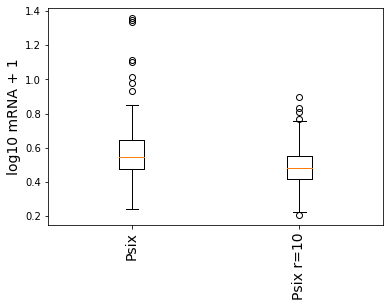

In [78]:
plt.boxplot([np.log10(tiklova_mrna_event.loc[pos_L]+1).mean(axis=1), 
             np.log10(tiklova_mrna_event.loc[pos_Lc]+1).mean(axis=1)])

plt.xticks(np.arange(1, 3), 
           ['Psix', 'Psix r=10'], fontsize=14, rotation=90)

plt.ylabel('log10 mRNA + 1', fontsize=14)
# plt.xlabel('Method', fontsize=14)
# plt.title('Method comparison', fontsize=14)


Text(0.5, 1.0, 'Exons that switch')

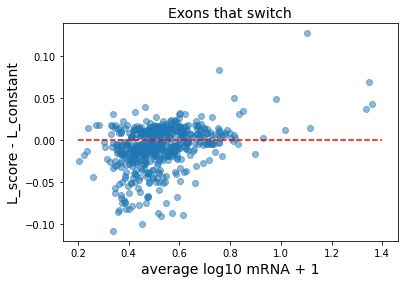

In [81]:
x = pos_L | pos_Lc
plt.scatter(np.log10(tiklova_mrna_event.loc[x]+1).mean(axis=1), (L_score_adj-L_constant_adj).loc[x], alpha=0.5)
plt.plot([0.2, 1.4], [0, 0], 'r--')
plt.xlabel('average log10 mRNA + 1', fontsize=14)
plt.ylabel('L_score - L_constant', fontsize=14)
plt.title('Exons that switch', fontsize=14)

In [68]:
spearmanr(np.log10(tiklova_mrna_event.loc[x]+1).mean(axis=1),
            (L_score_adj-L_constant_adj).loc[x])

SpearmanrResult(correlation=0.3440546907171368, pvalue=3.8086599554062156e-16)

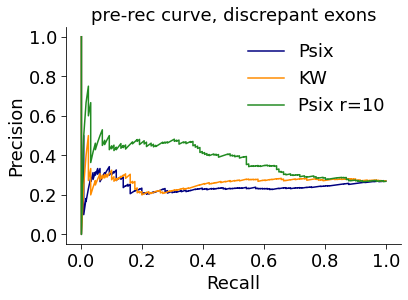

In [77]:
fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = pos_L | pos_Lc
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
psix_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
psix_y2 = list(tiklova_psix.loc[weyn_pos & exons].L_constant) + list(tiklova_psix.loc[weyn_neg & exons].L_constant)

kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, psix_y)
# pre2, rec2, thres2 = precision_recall_curve(y1, psix_y1)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)
pre4, rec4, thres4 = precision_recall_curve(y1, psix_y2)


plt.plot(rec1, pre1, c='navy', label='Psix')
# plt.plot(rec2, pre2, c='steelblue', label='Psix fixed')
plt.plot(rec3, pre3, c='darkorange', label='KW')
plt.plot(rec4, pre4, c='forestgreen', label='Psix r=10')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('pre-rec curve, discrepant exons', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

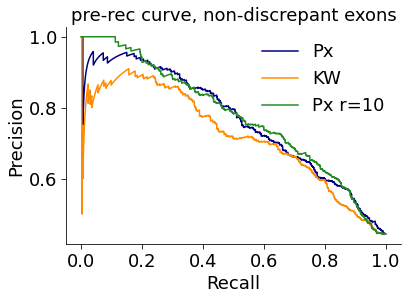

In [85]:
fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = pd.Index([x for x in tiklova_psix.index if x not in (pos_L | pos_Lc)])
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
psix_y = list(tiklova_psix.loc[weyn_pos & exons].L_score) + list(tiklova_psix.loc[weyn_neg & exons].L_score)
psix_y2 = list(tiklova_psix.loc[weyn_pos & exons].L_constant) + list(tiklova_psix.loc[weyn_neg & exons].L_constant)

kw_y = list(tiklova_kw.loc[weyn_pos & exons].KW_score) + list(tiklova_kw.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, psix_y)
# pre2, rec2, thres2 = precision_recall_curve(y1, psix_y1)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)
pre4, rec4, thres4 = precision_recall_curve(y1, psix_y2)


plt.plot(rec1, pre1, c='navy', label='Px')
# plt.plot(rec2, pre2, c='steelblue', label='Psix fixed')
plt.plot(rec3, pre3, c='darkorange', label='KW')
plt.plot(rec4, pre4, c='forestgreen', label='Px r=10')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('pre-rec curve, non-discrepant exons', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

In [16]:
binary_obs = (tiklova_PSI.loc[x] == 0) | (tiklova_PSI.loc[x] == 1) 
# binary_obs = binary_obs/ (~tiklova_PSI.loc[x].isna()).sum(axis=1)
binary_obs = binary_obs.astype(int).mask(tiklova_PSI.loc[x].isna())

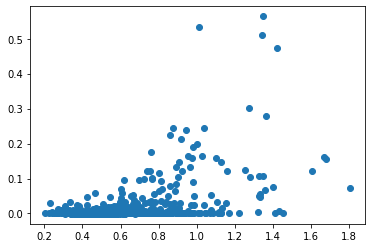

In [49]:
x = (L_score_adj-L_constant_adj).sort_values().index
plt.scatter(np.log10(tiklova_mrna_event.loc[x]+1).mean(axis=1), (L_score_adj * L_constant_adj).sort_values())

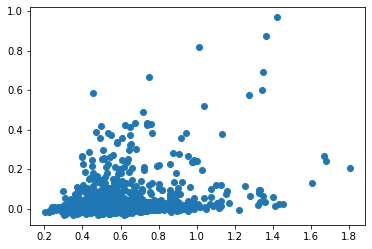

In [50]:
x = (L_score_adj).sort_values().index
plt.scatter(np.log10(tiklova_mrna_event.loc[x]+1).mean(axis=1), (L_score_adj).sort_values())

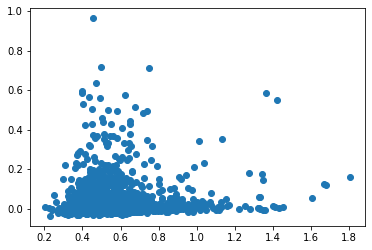

In [51]:
x = (L_constant_adj).sort_values().index
plt.scatter(np.log10(tiklova_mrna_event.loc[x]+1).mean(axis=1), (L_constant_adj).sort_values())

In [39]:
spearmanr(np.log10(tiklova_mrna_event.loc['Mapt_1']+1).dropna(), binary_obs.loc['Mapt_1'].dropna())

SpearmanrResult(correlation=-0.37321642035919456, pvalue=1.2447222328741536e-40)

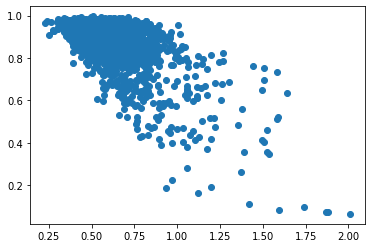

In [26]:
plt.scatter(np.log10(tiklova_mrna_event.loc[x].mean(axis=1)+1), binary_obs.mean(axis=1))

100%|██████████| 1988/1988 [00:05<00:00, 349.39it/s]


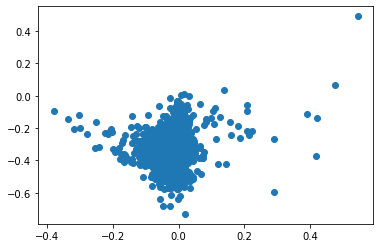

In [42]:
x = (L_score_adj-L_constant_adj).sort_values().index

corr_s = []
for exon in tqdm(x):
    try:
        corr_s.append(spearmanr(np.log10(tiklova_mrna_event.loc[exon]+1).dropna(), binary_obs.loc[exon].dropna())[0])
    except:
        corr_s.append(np.nan)

plt.scatter((L_score_adj-L_constant_adj).sort_values(), corr_s
)

(array([   5.,   10.,   52.,  626., 1269.,   12.,    7.,    2.,    3.,
           2.]),
 array([-0.37879697, -0.28644812, -0.19409927, -0.10175042, -0.00940157,
         0.08294728,  0.17529613,  0.26764498,  0.35999383,  0.45234268,
         0.54469153]),
 <a list of 10 Patch objects>)

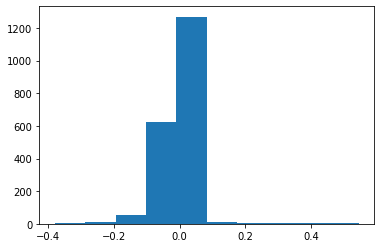

In [30]:
plt.hist((L_score_adj-L_constant_adj).sort_values())

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([726., 119.,  28.,  13.,   4.,   9.,   5.,   4.,  10., 272.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

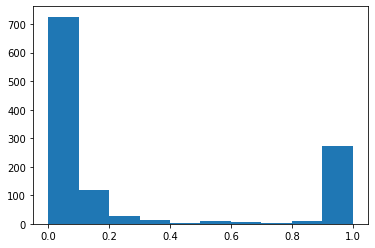

In [35]:
plt.hist(tiklova_PSI.loc['Mapt_1'])

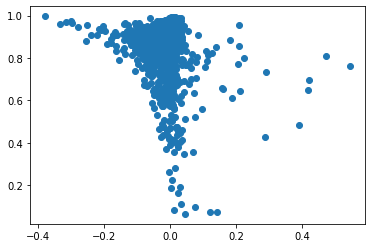

In [94]:
plt.scatter((L_score_adj-L_constant_adj).sort_values(),
    binary_obs
)

In [99]:
tiklova_kw.loc['Mapt_1']

KW_score     6.865210e+02
pvals       2.889012e-147
qvals       1.914452e-144
Name: Mapt_1, dtype: float64

In [93]:
weyn_ds.loc['Mapt_3']

E16     0.0000
P0      0.0005
P4      0.0005
P7      0.0140
P15     0.1210
P30     0.0925
P110    0.1300
M21     0.1010
Name: Mapt_3, dtype: float64

In [103]:
weyn_fdr.loc['Mapt_3']

E16     1.000000
P0      1.000000
P4      1.000000
P7      0.071543
P15     0.000000
P30     0.000000
P110    0.000000
M21     0.000000
Name: Mapt_3, dtype: float64

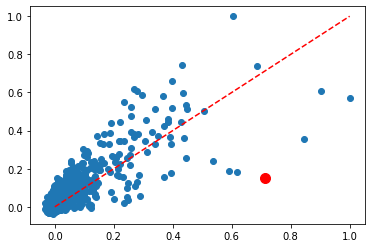

In [94]:
plt.scatter((tiklova_psix.L_score/np.max(tiklova_psix.L_score)),(tiklova_psix.L_constant/np.max(tiklova_psix.L_constant)))
plt.plot([0, 1], [0, 1], 'r--')

plt.scatter([tiklova_psix.loc['Mapt_3'].L_score/np.max(tiklova_psix.L_score)], 
            [tiklova_psix.loc['Mapt_3'].L_constant/np.max(tiklova_psix.L_constant)], c='red', s=100)

In [41]:
np.sum(np.log10(prob_num)-np.log10(prob_denom))/len(prob_num)

0.005565942886189858

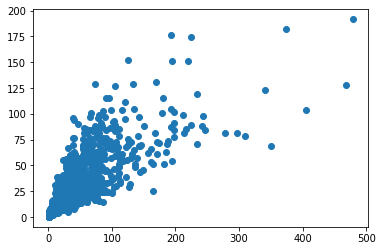

In [403]:
plt.scatter(tiklova_reads_adj.loc['Cadm1_10'], tiklova_mrna_event.loc['Cadm1_10'])